<a href="https://colab.research.google.com/github/Ben-Rapkin-Oberlin/374-Final-Project/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [30]:
#@title Imports
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import numpy as np
from google.colab import drive
import os
from PIL import Image as im

In [31]:
#@title Load Data
#for saving and loading
drive.mount('/content/gdrive')

#load data
x_train= tfds.load('div2k/realistic_wild_x4',split='train[:100%]', as_supervised=True, shuffle_files=True)
valid= tfds.load('div2k/realistic_wild_x4',split='validation[:100%]', as_supervised=True,shuffle_files=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
#@title Preprocess
#transform = T.ToPILImage()
def preprocess(x,y):
  #y is high res image, x is low res
  tensor2 = tf.cast(tf.image.resize(y, [512, 512]), tf.uint8)

  #loose info
  #tensor1 = tf.cast(tf.image.resize(tensor2, [128, 128]), tf.uint8)
  tensor1 = tf.cast(tf.image.resize(tensor2, [256, 256]), tf.uint8)
  tensor1=tf.image.resize(tensor1, [512, 512])
  tensor1=tensor1/255 # normalize, but for images, pixels must be int
  # in the future it would be better to inplement a custom loss function that cast
  # the output as int before finding the mse
  #tensor1 = tf.cast(tensor1, tf.uint8)

  return tensor1, tensor2


x_train = x_train.map(lambda x,y: preprocess(x,y))
valid = valid.map(lambda x,y: preprocess(x,y))


In [ ]:
#@title (optional test for preprocess)
#ensure that the preproccessing worked
a=x_train.take(1).__iter__()
next_element = a.get_next()
b=next_element[0]
c=next_element[1]
print(b[0][0])
b=b*255
print(b[0][0])
b=tf.cast(b, tf.uint8)
b=b.numpy()
print(b[0][0])
print(c[0][0])
c=c.numpy()
print(c.dtype)
print(c[0][0])
low = im.fromarray(b,'RGB')
high=im.fromarray(c,'RGB')

display(low)
display(high)

# Training

In [15]:
#@title Make Autoencoder
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=14000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  input_img = tf.keras.layers.Input(shape=(512, 512, 3))

  # Increase the number of filters in the convolutional layers to
  # better handle the increased resolution of the input and output images
  l1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
  l2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
  l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

  l4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
  l5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
  l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

  l7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

  # Add additional layers to handle the increased resolution of the input and output images
  l8 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l7)
  l9 = tf.keras.layers.UpSampling2D()(l8)
  l10 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)
  l11 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l10)

  l12 = tf.keras.layers.add([l11, l5])

  # Add additional layers to handle the increased resolution of the input and output images
  l13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
  l14 = tf.keras.layers.UpSampling2D()(l13)
  l15 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l14)
  l16 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

  l17 = tf.keras.layers.add([l16, l2])

  decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l17)

  auto_encoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)
  #auto_encoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['MeanSquaredError'])
  auto_encoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['MeanSquaredError'])

In [5]:
#@title Batch For Training 
#this is sperate becuase the batch is held in ram after an error,
#so rebatching will cause the program to crash if there is a small error below
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  x_train=x_train.batch(4)
  valid=valid.batch(4)
  print("GPU Batching")
else:
  x_train=x_train.batch(1)
  valid=valid.batch(1)
  print("CPU Batching")

GPU Batching


In [ ]:
#@title Train Model


#load model
path = F"/content/gdrive/My Drive/autoencoder" 
try:
  auto_encoder.load_weights(path)
  print('prior found')
except:
  print('no prior')

#set saving system
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_best_only=True,
                                                 #save_freq=1,
                                                 verbose=1, 
                                                 #monitor='val_mean_squared_error'
                                                 monitor='val_loss',
                                                 jit_compile=True                                
                                                 )

#fit model
history=auto_encoder.fit(
    x=x_train,
    validation_data=valid,
    #validation_steps=4,
    epochs=15,
    
    callbacks=[cp_callback])

#history.history

prior found
Epoch 1/15
800/800 [==============================] - ETA: 0s - loss: 345.9722 - mean_squared_error: 345.5313
Epoch 1: val_loss improved from inf to 245.40591, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1258s 2s/step - loss: 345.9722 - mean_squared_error: 345.5313 - val_loss: 245.4059 - val_mean_squared_error: 244.9762
Epoch 2/15
800/800 [==============================] - ETA: 0s - loss: 228.0078 - mean_squared_error: 227.5837
Epoch 2: val_loss improved from 245.40591 to 211.92165, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1205s 2s/step - loss: 228.0078 - mean_squared_error: 227.5837 - val_loss: 211.9216 - val_mean_squared_error: 211.5095
Epoch 3/15
800/800 [==============================] - ETA: 0s - loss: 214.1435 - mean_squared_error: 213.7275
Epoch 3: val_loss did not improve from 211.92165
800/800 [==============================] - 1203s 2s/step - loss: 214.1435 - mean_squared_error: 213.7275 - val_loss: 212.4961 - val_mean_squared_error: 212.0902
Epoch 4/15
800/800 [==============================] - ETA: 0s - loss: 218.3144 - mean_squared_error: 217.9202
Epoch 4: val_loss improved from 211.92165 to 203.43996, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1209s 2s/step - loss: 218.3144 - mean_squared_error: 217.9202 - val_loss: 203.4400 - val_mean_squared_error: 203.0545
Epoch 5/15
800/800 [==============================] - ETA: 0s - loss: 223.2823 - mean_squared_error: 222.9046
Epoch 5: val_loss did not improve from 203.43996
800/800 [==============================] - 1202s 2s/step - loss: 223.2823 - mean_squared_error: 222.9046 - val_loss: 203.6496 - val_mean_squared_error: 203.2979
Epoch 6/15
800/800 [==============================] - ETA: 0s - loss: 208.8063 - mean_squared_error: 208.4452
Epoch 6: val_loss did not improve from 203.43996
800/800 [==============================] - 1201s 1s/step - loss: 208.8063 - mean_squared_error: 208.4452 - val_loss: 210.8567 - val_mean_squared_error: 210.5093
Epoch 7/15
800/800 [==============================] - ETA: 0s - loss: 210.8955 - mean_squared_error: 210.5490
Epoch 7: val_loss improved from 203.43996 to 198.12326, saving model to /content/gdrive/M

800/800 [==============================] - 1200s 1s/step - loss: 210.8955 - mean_squared_error: 210.5490 - val_loss: 198.1233 - val_mean_squared_error: 197.7981
Epoch 8/15
800/800 [==============================] - ETA: 0s - loss: 200.3404 - mean_squared_error: 200.0145
Epoch 8: val_loss improved from 198.12326 to 197.14076, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1195s 1s/step - loss: 200.3404 - mean_squared_error: 200.0145 - val_loss: 197.1408 - val_mean_squared_error: 196.8326
Epoch 9/15
800/800 [==============================] - ETA: 0s - loss: 197.9785 - mean_squared_error: 197.6704
Epoch 9: val_loss improved from 197.14076 to 194.78621, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1195s 1s/step - loss: 197.9785 - mean_squared_error: 197.6704 - val_loss: 194.7862 - val_mean_squared_error: 194.4885
Epoch 10/15
800/800 [==============================] - ETA: 0s - loss: 199.2507 - mean_squared_error: 198.9698
Epoch 10: val_loss improved from 194.78621 to 194.46623, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1195s 1s/step - loss: 199.2507 - mean_squared_error: 198.9698 - val_loss: 194.4662 - val_mean_squared_error: 194.1982
Epoch 11/15
800/800 [==============================] - ETA: 0s - loss: 194.6667 - mean_squared_error: 194.3997
Epoch 11: val_loss improved from 194.46623 to 194.19815, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1195s 1s/step - loss: 194.6667 - mean_squared_error: 194.3997 - val_loss: 194.1982 - val_mean_squared_error: 193.9502
Epoch 12/15
800/800 [==============================] - ETA: 0s - loss: 194.7478 - mean_squared_error: 194.5121
Epoch 12: val_loss improved from 194.19815 to 192.13521, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1195s 1s/step - loss: 194.7478 - mean_squared_error: 194.5121 - val_loss: 192.1352 - val_mean_squared_error: 191.9065
Epoch 13/15
800/800 [==============================] - ETA: 0s - loss: 192.5880 - mean_squared_error: 192.3640
Epoch 13: val_loss improved from 192.13521 to 190.00578, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1196s 1s/step - loss: 192.5880 - mean_squared_error: 192.3640 - val_loss: 190.0058 - val_mean_squared_error: 189.7957
Epoch 14/15
  3/800 [..............................] - ETA: 19:24 - loss: 173.4320 - mean_squared_error: 173.2167

In [16]:
#@title Batch for Testing Model
x_train=x_train.batch(1)

tf.Tensor([0.8352941 0.9137255 0.9843137], shape=(3,), dtype=float32)
1/1 [==============================] - 28s 28s/step
shape new (1, 512, 512, 3)
old dtype float32
new dtype uint8
[208 231 242]
[209 233 249]
[208 231 242]
[209 233 249]
[217 234 252]
[212 233 251]


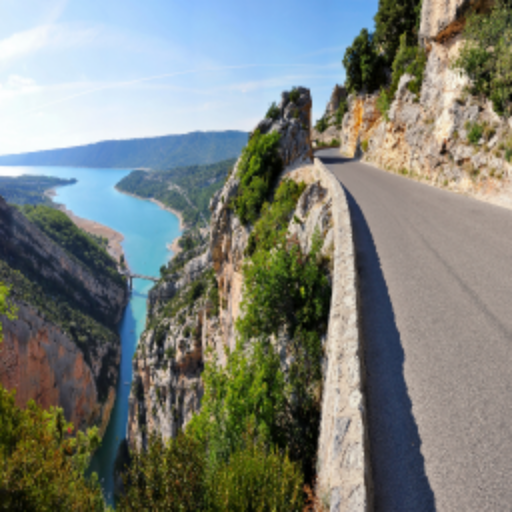

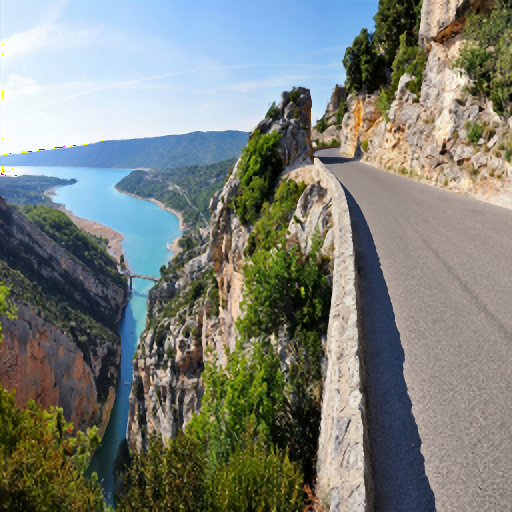

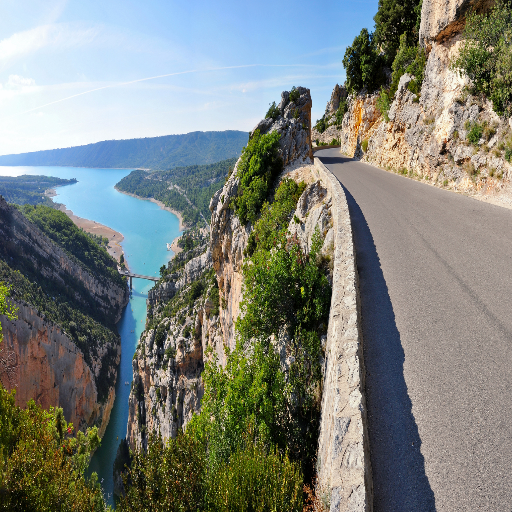

In [17]:
#@title Test Model on Dataset
#test the model's output after some training
a=x_train.take(1).__iter__()
next_element = a.get_next()
test=next_element[0]
label=next_element[1]
label=label[0]
path = F"/content/gdrive/My Drive/autoencoder" 
auto_encoder.load_weights(path)
#print(test.shape)
print(test[0][0][0])
#print(test[1][1])

new=auto_encoder.predict(test)

print("shape new", new.shape)
new=new[0]
print("old dtype",new.dtype)
new=tf.convert_to_tensor(new)
new=b=tf.cast(new, tf.uint8)
new=new.numpy()
print("new dtype",new.dtype)
print(new[0][0])
print(new[1][1])

test=test[0]
test=test*255
test=tf.cast(test, tf.uint8)


label=label.numpy()

print(new[0][0])
print(new[1][1])
print(label[0][0])
print(label[1][1])



label=im.fromarray(label,'RGB')
new=im.fromarray(new,'RGB')
test=im.fromarray(test.numpy(),'RGB')

display(test)
display(new)
display(label)

# Crop for Paper

In [34]:
from PIL import Image as im
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
import os
print(os.listdir("."))


['.config', 'gdrive', 'out2.png', 'in2.png', '~', '70.jpg', 'The Fireside Angel (The Triump)-Max Ernst.jpg', 'sol2.png', 'sample_data']


(512, 512)


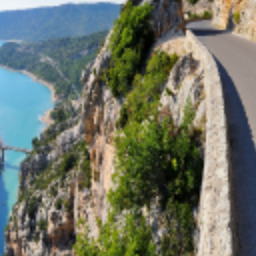

(512, 512)


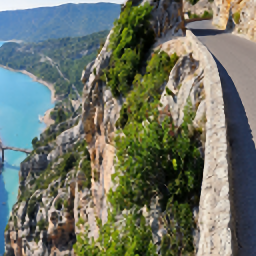

(512, 512)


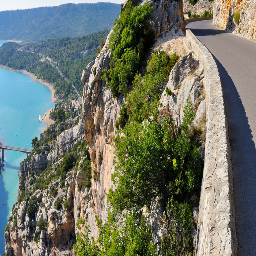

In [28]:
#path=['./in2.png','./out2.png','./sol2.png']

for i in path:
  im1 = im1.resize(newsize)
  img=im.open(i)
  #im1 = im.crop((left, top, right, bottom))
  print(img.size)
  img=img.crop((128,128,512-128,512-128))
  display(img)

In [33]:
uploaded = files.upload()
import os
print(os.listdir("."))


Saving 70.jpg to 70.jpg
['.config', 'gdrive', 'out2.png', 'in2.png', '~', '70.jpg', 'The Fireside Angel (The Triump)-Max Ernst.jpg', 'sol2.png', 'sample_data']


shape a (1, 512, 512, 3)
1/1 [==============================] - 10s 10s/step
shape new (1, 512, 512, 3)
shape new (512, 512, 3)


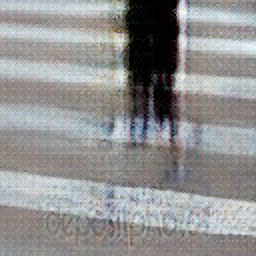

In [41]:
import numpy as np
img=im.open('70.jpg')
img=img.resize((512,512))
a=np.asarray(img)
a=np.expand_dims(a, axis=0)
a=a/255
print("shape a", a.shape)

path = F"/content/gdrive/My Drive/autoencoder" 
auto_encoder.load_weights(path)
new=auto_encoder.predict(a)

print("shape new", new.shape)
new=new[0]
print("shape new", new.shape)
new=tf.convert_to_tensor(new)
new=b=tf.cast(new, tf.uint8)
new=new.numpy()





new=im.fromarray(new,'RGB')
new=new.crop((128,128,512-128,512-128))

display(new)
